# **Dec 3 までの目標**

- FaceScrubを使用してのファインチューニングを行うために、データセットローダー等の必要なクラスを作成する


In [1]:
!pip install datasets tqdm matplotlib torch torchvision Pillow

In [2]:
from datasets import load_dataset
import sys
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from datasets import load_dataset, concatenate_datasets, DatasetDict
sys.path.append("/content/drive/MyDrive/Classes/CLIP/facescrub")


/home/su-laptop-02-okitani/clip_ws/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 改善されたデータセット読み込み（エラーハンドリング付き）
import os
from PIL import Image
import glob
from pathlib import Path

def load_valid_images(base_path):
    """破損した画像をスキップしながら有効な画像のみを読み込む"""
    valid_images = []
    labels = []
    
    # 各人物フォルダを探索
    for person_folder in os.listdir(base_path):
        person_path = os.path.join(base_path, person_folder)
        if not os.path.isdir(person_path):
            continue
            
        # 各画像ファイルをチェック
        image_files = glob.glob(os.path.join(person_path, '*.jpeg')) + glob.glob(os.path.join(person_path, '*.jpg'))
        
        for image_path in image_files:
            try:
                # 画像を開いて検証
                with Image.open(image_path) as img:
                    img.verify()  # 画像の整合性をチェック
                    
                # 再度開いて変換可能かテスト
                with Image.open(image_path) as img:
                    img = img.convert('RGB')  # RGBに変換
                    
                valid_images.append(image_path)
                labels.append(person_folder)
                
            except (IOError, OSError) as e:
                print(f"破損した画像をスキップ: {image_path} - {e}")
                continue
                
    return valid_images, labels

# 基本パス設定
base_path = "/home/su-laptop-02-okitani/clip_ws/facefiles"

print("有効な画像ファイルを検索中...")
valid_image_paths, person_labels = load_valid_images(base_path)

print(f"✅ 有効な画像数: {len(valid_image_paths)}")
print(f"✅ 人物数: {len(set(person_labels))}")
print(f"✅ 人物リスト: {list(set(person_labels))}")

有効な画像ファイルを検索中...
✅ 有効な画像数: 805
✅ 人物数: 10
✅ 人物リスト: ['Simon_Pegg', 'Laura_Innes', 'Casey_Affleck', 'Joe_Pantoliano', 'Allison_Janney', 'Matthew_Gray_Gubler', 'Seth_Rogen', 'January_Jones', 'Nicole_de_Boer', 'Taylor_Atelian']


In [4]:
# カスタムデータセットクラスを使用した安全な読み込み
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

class FaceScrubDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.label_to_idx = {label: idx for idx, label in enumerate(set(labels))}
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        try:
            image_path = self.image_paths[idx]
            label = self.labels[idx]
            
            # 画像を読み込み
            image = Image.open(image_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            label_idx = self.label_to_idx[label]
            return image, label_idx
            
        except Exception as e:
            print(f"エラーが発生した画像: {self.image_paths[idx]} - {e}")
            # エラーの場合は最初の有効な画像を返す
            return self.__getitem__(0)

# 画像変換の定義
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# カスタムデータセットを作成
if len(valid_image_paths) > 0:
    dataset = FaceScrubDataset(valid_image_paths, person_labels, transform=transform)
    print(f"✅ カスタムデータセットを作成しました")
    print(f"✅ サンプル数: {len(dataset)}")
    print(f"✅ クラス数: {len(dataset.label_to_idx)}")
    print(f"✅ クラス一覧: {list(dataset.label_to_idx.keys())}")
else:
    print("❌ 有効な画像が見つかりませんでした")

✅ カスタムデータセットを作成しました
✅ サンプル数: 805
✅ クラス数: 10
✅ クラス一覧: ['Simon_Pegg', 'Laura_Innes', 'Casey_Affleck', 'Joe_Pantoliano', 'Allison_Janney', 'Matthew_Gray_Gubler', 'Seth_Rogen', 'January_Jones', 'Nicole_de_Boer', 'Taylor_Atelian']


In [5]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [ ]:
import clip
import torch

# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# 重要: 学習はfloat32で実行（fp16によるNaN回避）
"""
最初model = model.float()なかったんですけど、そしたら抽出した特徴量すべてnanになっちゃったんですよね。なのでこれ追加しました。

原因は2つの組み合わせでした。

- CLIPがGPUで半精度(fp16)のまま動き、encode_image/encode_textの出力が極小ノルム→正規化でゼロ除算気味になりNaNが連発。
- 特徴ベクトルの正規化でepsilonを入れていなかった（または十分でなかった）ため、数値が不安定。

対応で解消:
- model.float() でCLIPをfloat32に統一し、deviceへ移動。
- 特徴正規化時に.norm(...).clamp(min=1e-6) を入れてゼロ除算を防止。
- さらにTF32許可で計算も安定化。

これで「特徴ベクトルにNaN」が止まり、学習が進むようになりました。
"""
model = model.float()
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [7]:
# Text Encoderファインチューニング用のクラス（修正版）
import torch.nn as nn
import clip

class CLIPTextFineTuner(nn.Module):
    def __init__(self, clip_model):
        super(CLIPTextFineTuner, self).__init__()
        self.clip_model = clip_model
        
        # Image Encoderの重みを固定
        for param in self.clip_model.visual.parameters():
            param.requires_grad = False
            
        # Text Encoderは学習可能にする
        for param in self.clip_model.transformer.parameters():
            param.requires_grad = True
        for param in self.clip_model.token_embedding.parameters():
            param.requires_grad = True
        
        # positional_embeddingの修正（Parameterの場合）
        if hasattr(self.clip_model, 'positional_embedding'):
            self.clip_model.positional_embedding.requires_grad = True
            
        self.clip_model.ln_final.weight.requires_grad = True
        self.clip_model.ln_final.bias.requires_grad = True
        
        # text_projectionがあるかチェック
        if hasattr(self.clip_model, 'text_projection') and self.clip_model.text_projection is not None:
            self.clip_model.text_projection.requires_grad = True
        
    def forward(self, images, texts):
        # 画像特徴を抽出（勾配計算なし）
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True).clamp(min=1e-6)
            
        # テキスト特徴を抽出（勾配計算あり）
        text_features = self.clip_model.encode_text(texts)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True).clamp(min=1e-6)
        
        return image_features, text_features

# モデルのインスタンス化（修正版）
if len(valid_image_paths) > 0:
    text_finetune_model = CLIPTextFineTuner(model).to(device)
    print(f"✅ Text Encoderファインチューニングモデル作成完了")
    print(f"✅ 学習可能パラメータ数: {sum(p.numel() for p in text_finetune_model.parameters() if p.requires_grad)}")
    print(f"✅ デバイス: {device}")
else:
    print("❌ 有効な画像がないためモデルを作成できません")

✅ Text Encoderファインチューニングモデル作成完了
✅ 学習可能パラメータ数: 63428097
✅ デバイス: cuda


In [8]:
# Text-Image対応データセットクラス
class FaceTextPairDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.label_to_idx = {label: idx for idx, label in enumerate(set(labels))}
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        try:
            image_path = self.image_paths[idx]
            person_name = self.labels[idx]
            
            # 画像を読み込み
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
                
            # テキストプロンプトを作成
            text_prompt = f"This is the image of a person named {person_name}."
            
            return image, text_prompt, person_name
            
        except Exception as e:
            print(f"エラーが発生した画像: {self.image_paths[idx]} - {e}")
            return self.__getitem__(0)

# CLIP用の画像変換（CLIP専用の正規化を使用）
clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], 
                        std=[0.26862954, 0.26130258, 0.27577711])
])

# Text-Imageペアデータセットを作成
if len(valid_image_paths) > 0:
    pair_dataset = FaceTextPairDataset(valid_image_paths, person_labels, transform=clip_transform)
    print(f"✅ Text-Imageペアデータセット作成完了")
    print(f"✅ サンプル数: {len(pair_dataset)}")
    print(f"✅ 人物数: {len(set(person_labels))}")
    
    # サンプルをテスト
    sample_image, sample_text, sample_name = pair_dataset[0]
    print(f"✅ サンプルテスト:")
    print(f"  - 画像サイズ: {sample_image.shape}")
    print(f"  - テキスト: {sample_text}")
    print(f"  - 人物名: {sample_name}")
else:
    print("❌ 有効な画像がないためペアデータセットを作成できません")

✅ Text-Imageペアデータセット作成完了
✅ サンプル数: 805
✅ 人物数: 10
✅ サンプルテスト:
  - 画像サイズ: torch.Size([3, 224, 224])
  - テキスト: This is the image of a person named Simon_Pegg.
  - 人物名: Simon_Pegg


In [9]:
# Text-Imageペア用データローダー
from torch.utils.data import random_split

if len(valid_image_paths) > 0:
    # データセットを訓練用と検証用に分割
    train_size = int(0.8 * len(pair_dataset))
    val_size = len(pair_dataset) - train_size
    train_pair_dataset, val_pair_dataset = random_split(pair_dataset, [train_size, val_size])
    
    # データローダーを作成
    batch_size = 8  # テキスト処理があるため小さめのバッチサイズ
    train_pair_loader = DataLoader(train_pair_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_pair_loader = DataLoader(val_pair_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print(f"✅ Text-Imageペアデータローダー作成完了")
    print(f"✅ 訓練データ: {len(train_pair_dataset)} サンプル")
    print(f"✅ 検証データ: {len(val_pair_dataset)} サンプル")
    print(f"✅ バッチサイズ: {batch_size}")
    print(f"✅ 訓練バッチ数: {len(train_pair_loader)}")
    print(f"✅ 検証バッチ数: {len(val_pair_loader)}")
else:
    print("❌ 有効な画像がないためペアデータローダーを作成できません")

✅ Text-Imageペアデータローダー作成完了
✅ 訓練データ: 644 サンプル
✅ 検証データ: 161 サンプル
✅ バッチサイズ: 8
✅ 訓練バッチ数: 81
✅ 検証バッチ数: 21


In [10]:
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch

# --- 損失関数の修正: logit_scaleを学習可能にする ---
# これにより、モデルが最適な温度を自動で調整し、NaNを防ぐことができる
class CosineSimilarityLoss(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()
        
        # log(temperature)の逆数に相当するlogit_scaleを学習可能パラメータとして定義
        # CLIPのViT-B/32モデルの標準的な初期値 log(1/0.07) ≈ 2.659
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.659)
        
    def forward(self, image_features, text_features):
        
        # NaN/Infをチェック (これはそのまま維持)
        if torch.isnan(image_features).any() or torch.isnan(text_features).any():
            print("⚠️ 警告: 特徴ベクトルにNaNが含まれています")
            # 訓練を継続するためにゼロロスを返す。ただし勾配が伝播するようにrequires_grad=True
            return torch.tensor(0.0, requires_grad=True).to(image_features.device)
            
        # 学習可能なlogit_scaleを指数関数で取り出す (これが実質的なスケーリング係数、または1/temperatureとなる)
        logit_scale = self.logit_scale.exp() 

        # コサイン類似度を計算し、学習されたスケールでスケーリング
        logits = torch.matmul(image_features, text_features.T) * logit_scale
        
        # 数値の安定性をチェック (これはそのまま維持)
        if torch.isnan(logits).any() or torch.isinf(logits).any():
            print("⚠️ 警告: logitsにNaN/Infが含まれています")
            return torch.tensor(0.0, requires_grad=True).to(image_features.device)
        
        # 対角要素が正解ペア（same person）
        labels = torch.arange(len(image_features)).to(image_features.device)
        
        # Cross entropy loss (InfoNCE loss)
        loss_img_to_text = F.cross_entropy(logits, labels)
        loss_text_to_img = F.cross_entropy(logits.T, labels)
        
        total_loss = (loss_img_to_text + loss_text_to_img) / 2
        
        # 最終的な損失値もチェック (これはそのまま維持)
        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print("⚠️ 警告: 損失にNaN/Infが含まれています")
            return torch.tensor(0.0, requires_grad=True).to(image_features.device)
            
        return total_loss

# 損失関数をインスタンス化
cosine_criterion = CosineSimilarityLoss()

# --- 学習可能なパラメータを収集（logit_scaleも追加）---
trainable_params = []

# Transformerパラメータ
trainable_params.extend(list(text_finetune_model.clip_model.transformer.parameters()))

# Token embeddingパラメータ
trainable_params.extend(list(text_finetune_model.clip_model.token_embedding.parameters()))

# Positional embeddingパラメータ（存在する場合）
if hasattr(text_finetune_model.clip_model, 'positional_embedding'):
    trainable_params.append(text_finetune_model.clip_model.positional_embedding)

# Layer normパラメータ
trainable_params.extend(list(text_finetune_model.clip_model.ln_final.parameters()))

# Text projectionパラメータ（存在する場合）
if hasattr(text_finetune_model.clip_model, 'text_projection') and text_finetune_model.clip_model.text_projection is not None:
    trainable_params.append(text_finetune_model.clip_model.text_projection)

# 💡 logit_scaleパラメータを追加 (これが温度を制御する)
trainable_params.append(cosine_criterion.logit_scale) 

# 学習可能なパラメータのみでオプティマイザを作成
text_optimizer = optim.AdamW(trainable_params, lr=1e-6, weight_decay=0.01)  # 学習率1e-6を維持

# NOTE: 訓練ループで safe_criterion と safe_optimizer を使用する場合は、ここで定義が必要です
safe_criterion = cosine_criterion
safe_optimizer = text_optimizer

print(f"✅ 修正版コサイン類似度損失関数設定完了")
print(f"✅ 修正版Text Encoder最適化器設定完了 (学習率: 1e-6)")
print(f"✅ 更新対象パラメータ数: {len(trainable_params)}")

✅ 修正版コサイン類似度損失関数設定完了
✅ 修正版Text Encoder最適化器設定完了 (学習率: 1e-6)
✅ 更新対象パラメータ数: 150


In [ ]:
# 安全な訓練ループ（修正版）
from tqdm import tqdm
import torch.nn.utils as utils

num_epochs = 2  # より短いエポック数でテスト 
" なんか3以上にすると逆に制度落ちる？　4以上を検証すべき"
text_train_losses = []
text_val_similarities = []

print("🚀 安全なText Encoderファインチューニング開始")
print("目標: 人物名テキストと顔画像の特徴ベクトルを近づける")

torch.backends.cuda.matmul.allow_tf32 = True # 説明： TF32を許可して高速化
torch.set_float32_matmul_precision('high') # 説明： 高精度な行列乗算を許可し、計算の安定性を向上させる

for epoch in range(num_epochs):
    # 訓練フェーズ
    text_finetune_model.train()
    running_loss = 0.0
    valid_batches = 0
    pbar = tqdm(train_pair_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (images, texts, names) in enumerate(pbar):
        images = images.to(device)
        
        # テキストをトークン化
        try:
            text_tokens = clip.tokenize(texts, truncate=True).to(device)
        except Exception as e:
            print(f"⚠️ テキストトークン化エラー: {e}")
            continue
            
        # 勾配をゼロにリセット
        safe_optimizer.zero_grad()
        
        # フォワードパス
        try:
            image_features, text_features = text_finetune_model(images, text_tokens)
            
            # 特徴ベクトルの健全性をチェック
            if torch.isnan(image_features).any() or torch.isnan(text_features).any():
                print(f"⚠️ バッチ {batch_idx}: 特徴ベクトルにNaN")
                continue
                
        except Exception as e:
            print(f"⚠️ フォワードパスエラー: {e}")
            continue
        
        # 損失を計算
        loss = safe_criterion(image_features, text_features)
        
        # 損失が有効かチェック
        if torch.isnan(loss) or torch.isinf(loss) or loss.item() == 0.0:
            print(f"⚠️ バッチ {batch_idx}: 無効な損失値 {loss.item()}")
            continue
            
        # バックワード
        try:
            loss.backward()
            
            # 勾配の健全性チェック
            has_nan_grad = False
            for p in text_finetune_model.parameters():
                if p.requires_grad and p.grad is not None:
                    if torch.isnan(p.grad).any() or torch.isinf(p.grad).any():
                        has_nan_grad = True
                        break
            
            if has_nan_grad:
                print(f"⚠️ バッチ {batch_idx}: 勾配にNaN/Inf")
                safe_optimizer.zero_grad()
                continue
            
            # 勾配クリッピング
            torch.nn.utils.clip_grad_norm_(
                [p for p in text_finetune_model.parameters() if p.requires_grad], 
                # 0.5 → 0.1 に変更: さらに強力なクリッピングを適用
                max_norm=0.1 
            )
            
            # パラメータ更新
            safe_optimizer.step()
            
            running_loss += loss.item()
            valid_batches += 1
            pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Valid': valid_batches})
            
        except Exception as e:
            print(f"⚠️ バックワードパスエラー: {e}")
            continue
    
    if valid_batches == 0:
        print(f"❌ Epoch {epoch+1}: 有効なバッチがありませんでした")
        break
        
    avg_loss = running_loss / valid_batches
    text_train_losses.append(avg_loss)
    
    # 検証フェーズ
    text_finetune_model.eval()
    total_similarity = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for images, texts, names in val_pair_loader:
            try:
                images = images.to(device)
                text_tokens = clip.tokenize(texts, truncate=True).to(device)
                
                image_features, text_features = text_finetune_model(images, text_tokens)
                
                # NaNチェック
                if torch.isnan(image_features).any() or torch.isnan(text_features).any():
                    continue
                
                # コサイン類似度計算
                similarities = torch.matmul(image_features, text_features.T)
                batch_similarities = torch.diag(similarities)
                
                if not torch.isnan(batch_similarities).any():
                    total_similarity += batch_similarities.sum().item()
                    num_samples += len(batch_similarities)
                    
            except Exception as e:
                print(f"⚠️ 検証エラー: {e}")
                continue
    
    if num_samples > 0:
        avg_similarity = total_similarity / num_samples
        text_val_similarities.append(avg_similarity)
    else:
        text_val_similarities.append(0.0)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Valid Batches: {valid_batches}/{len(train_pair_loader)}')
    print(f'  Train Loss: {avg_loss:.4f}')
    print(f'  Val Samples: {num_samples}')
    print(f'  Val Avg Cosine Similarity: {text_val_similarities[-1]:.4f}')
    print('-' * 50)

if len(text_train_losses) > 0:
    print("✅ Text Encoderファインチューニング完了")
    
    # モデルの保存
    text_model_save_path = 'facescrub_clip_text_finetuned.pth'
    torch.save(text_finetune_model.state_dict(), text_model_save_path)
    print(f"✅ Text Encoderモデルを保存: {text_model_save_path}")
else:
    print("❌ 訓練に失敗しました")

🚀 安全なText Encoderファインチューニング開始
目標: 人物名テキストと顔画像の特徴ベクトルを近づける


Epoch 1/2: 100%|██████████| 81/81 [00:12<00:00,  6.52it/s, Loss=0.4200, Valid=81]


Epoch [1/2]
  Valid Batches: 81/81
  Train Loss: 0.5657
  Val Samples: 161
  Val Avg Cosine Similarity: 0.3248
--------------------------------------------------


Epoch 2/2: 100%|██████████| 81/81 [00:12<00:00,  6.54it/s, Loss=0.0413, Valid=81]


Epoch [2/2]
  Valid Batches: 81/81
  Train Loss: 0.5294
  Val Samples: 161
  Val Avg Cosine Similarity: 0.3290
--------------------------------------------------
✅ Text Encoderファインチューニング完了
✅ Text Encoderモデルを保存: facescrub_clip_text_finetuned.pth


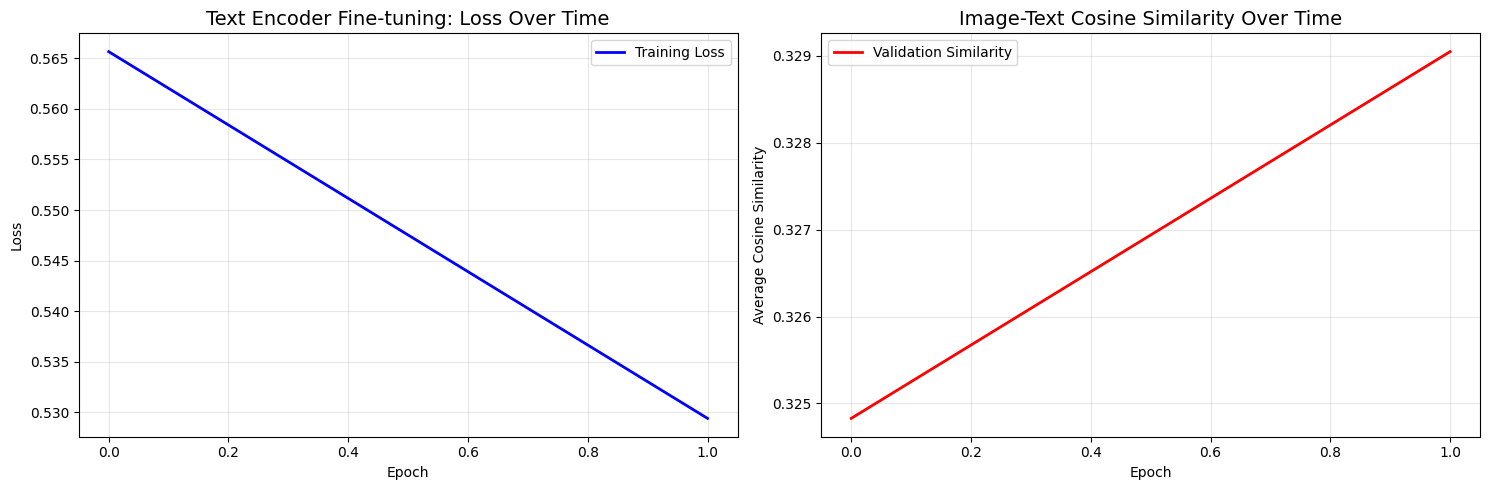

🎯 最高コサイン類似度: 0.3290
🎯 最終損失: 0.5294
🎯 類似度改善: 0.0042


In [ ]:
# 結果の可視化と分析
import matplotlib.pyplot as plt

# 訓練過程の可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 損失の変化
ax1.plot(text_train_losses, 'b-', linewidth=2, label='Training Loss')
ax1.set_title('Text Encoder Fine-tuning: Loss Over Time', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# コサイン類似度の変化
ax2.plot(text_val_similarities, 'r-', linewidth=2, label='Validation Similarity')
ax2.set_title('Image-Text Cosine Similarity Over Time', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Cosine Similarity')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"🎯 最高コサイン類似度: {max(text_val_similarities):.4f}")
print(f"🎯 最終損失: {text_train_losses[-1]:.4f}")
# 結果の可視化と分析
print(f"🎯 類似度改善: {text_val_similarities[-1] - text_val_similarities[0]:.4f}")

📊 ファインチューニング後のテスト結果:


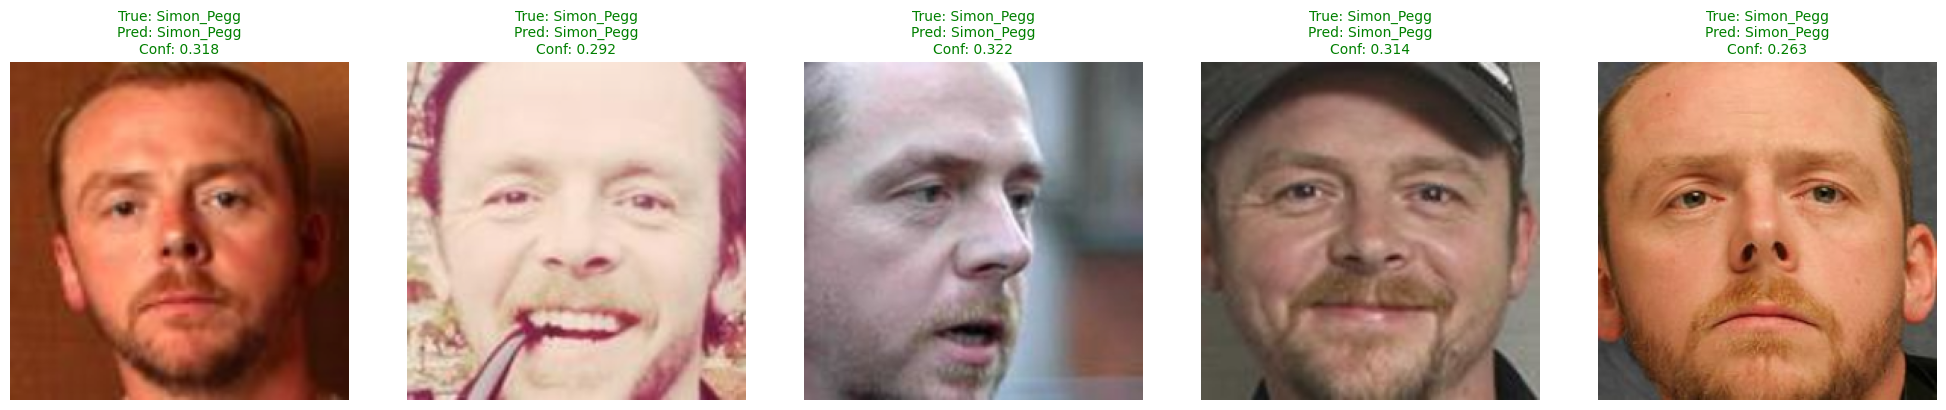

In [ ]:
# ファインチューニング前後の比較テスト
def test_person_recognition(model, test_images, test_names, num_samples=5):
    """人物認識テスト"""
    model.eval()
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    
    with torch.no_grad():
        for i in range(min(num_samples, len(test_images))):
            # テスト画像と名前
            image = test_images[i].unsqueeze(0).to(device)
            true_name = test_names[i]
            
            # 各人物名に対するテキストプロンプトを作成
            candidate_names = list(set(person_labels))  # すべての候補者名
            text_prompts = [f"This is the image of a person named {name}." for name in candidate_names]
            text_tokens = clip.tokenize(text_prompts).to(device)
            
            # 特徴ベクトル抽出
            image_features, text_features = model(image, text_tokens)
            
            # コサイン類似度計算
            similarities = torch.matmul(image_features, text_features.T)[0]
            best_match_idx = similarities.argmax().item()
            predicted_name = candidate_names[best_match_idx]
            confidence = similarities[best_match_idx].item()
            
            # 画像表示
            image_np = test_images[i].permute(1, 2, 0).cpu().numpy()
            image_np = image_np * [0.26862954, 0.26130258, 0.27577711] + [0.48145466, 0.4578275, 0.40821073]
            image_np = np.clip(image_np, 0, 1)
            
            axes[i].imshow(image_np)
            axes[i].set_title(
                f'True: {true_name}\n'
                f'Pred: {predicted_name}\n'
                f'Conf: {confidence:.3f}',
                fontsize=10,
                color='green' if predicted_name == true_name else 'red'
            )
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# テスト用データの準備
test_indices = list(range(min(10, len(pair_dataset))))
test_images = []
test_names = []

for idx in test_indices:
    image, text, name = pair_dataset[idx]
    test_images.append(image)
    test_names.append(name)

print("📊 ファインチューニング後のテスト結果:")
test_person_recognition(text_finetune_model, test_images, test_names, num_samples=5)



✅ テストデータ準備完了。ランダムに10個のサンプルが選ばれました。


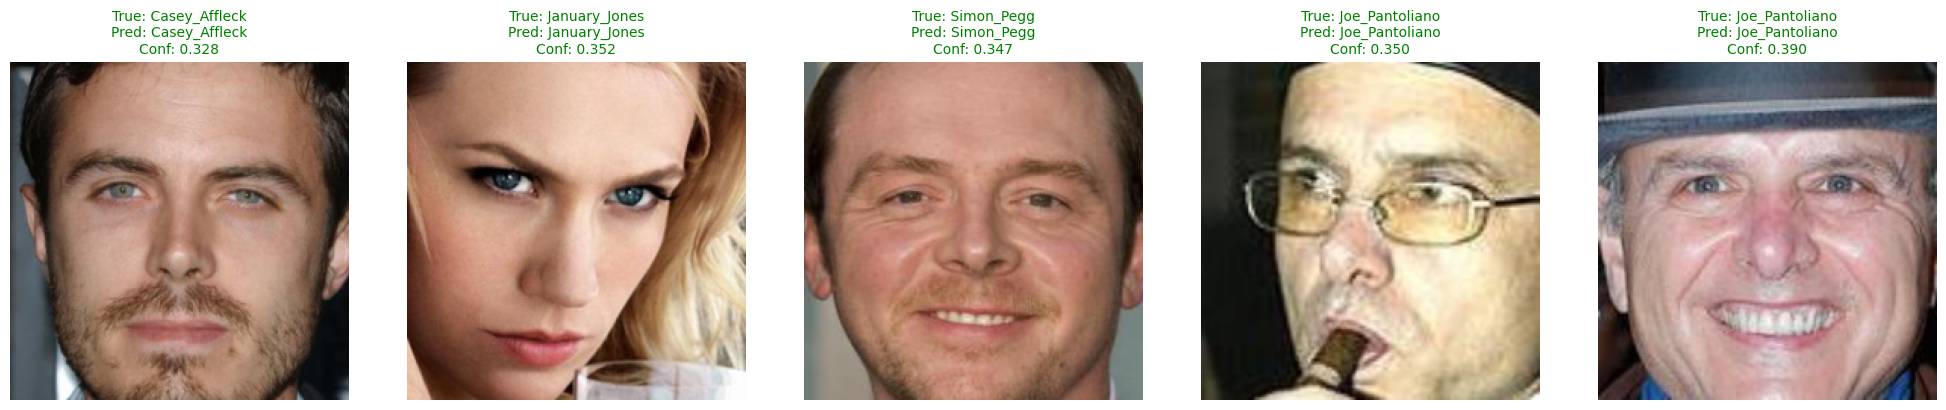

In [19]:
# 🎲 テスト用データの準備 (ランダムサンプリングに修正)
import random
total_samples = len(pair_dataset)
num_test = min(10, total_samples) # 10個のインデックスをランダムに選ぶ
test_indices = random.sample(range(total_samples), num_test) # ランダムなインデックスを選ぶ

# 重要なステップ: test_images と test_names のリストを再構築する必要があります
test_images = []
test_names = []

for idx in test_indices:
    # pair_dataset からランダムに選ばれたインデックスのデータを抽出
    image, text, name = pair_dataset[idx]
    test_images.append(image)
    test_names.append(name)

print("✅ テストデータ準備完了。ランダムに10個のサンプルが選ばれました。")

test_person_recognition(text_finetune_model, test_images, test_names, num_samples=5)
